# Project work: A mini segmentation challenge

Imaging for the Life Sciences  
MSLS / CO4: Project work

**Student**: $\Rightarrow$  Guansheng Du    
**University**: $\Rightarrow$  ZHAW  
**Semester**: $\Rightarrow$  SS24   
**Date**: $\Rightarrow$  26.05.2024 




## Table of contents

<!-- Unfortunately, the following does not always work correctly -->

* [1. Dataset](#sec_dataset)  
* [2. Preprocessing](#sec_preprocessing)  
* [3. Manual segmentation](#sec_manual_segmentation)  
* [4. Automated segmentation](#sec_automated_segmentation)  
* [5. Evaluation](#sec_evaluation)  
* [6. Discussion](#sec_discussion)  



## Introduction

Lower-grade gliomas (LGG), classified as WHO grade II and III brain tumors, are the focus of this mini project. I developed a neural network-based program to segment the cancerous regions from a series of MRI brain images. This dataset comprises brain MR images along with manually segmented FLAIR abnormality masks.

The images are associated with 110 patients from The Cancer Genome Atlas (TCGA) lower-grade glioma collection, all of whom have at least one fluid-attenuated inversion recovery (FLAIR) sequence. Out of these, 101 patients had all sequences available (pre-contrast, FLAIR, and post-contrast sequences), 9 patients lacked the post-contrast sequence, and 6 were missing the pre-contrast sequence.

In this project, images known to have valid tumor masks were loaded into a dataframe `df_mask`. A total of 1373 images were loaded into the dataset, with 80% used for training and the remaining 20% used for validation. These images were augmented and then trained using a U-Net architecture deep learning model. The Adam optimizer was used for optimization, and the Dice coefficient was used as the loss function. The learning rate was set to 0.001. After 50 training epochs, the model achieved a loss of 0.1628 on the training dataset and 0.1807 on the validation dataset. This small course project demonstrates the potential for segmenting tumor regions from brain MRI images.


---

## Prerequisites / Setup

$\Rightarrow$  Special setup instructions, imports and configurations go here.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import pydicom
import PIL
from PIL import Image
import os
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as transforms
from torch import optim

from torch.utils.data import Dataset


# Jupyter / IPython configuration:
# Automatically reload modules when modified
%load_ext autoreload
%autoreload 2

# Enable vectorized output (for nicer plots)
%config InlineBackend.figure_formats = ["svg"]

# Inline backend configuration
%matplotlib inline

# Enable this line if you want to use the interactive widgets
# It requires the ipympl package to be installed.
#%matplotlib widget

data_folder = '/home/gs/Desktop/SS24 CO4 Imaging for the Life Sciences/MRI_segmentation_data/raw/'



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Help functions

In [45]:
# Sort filenames in natural order
# Generated by AI

import re

def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)



In [46]:
# Check if the file has a mask

def check_mask(file):
    # Open the file
    image = Image.open(file)

    # Convert the image to an array
    image_array = np.array(image)

    # Check if there is a white pixel
    if np.any(image_array > 0):
        return 1
    else:
        return 0

In [47]:
def overlay_mask(image, mask):
    image = np.array(image)
    mask = np.array(mask)
    mask = mask > 0.5
    mask = mask.astype(np.uint8)

    mask = mask * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(image, contours, -1, (0, 255, 0), 1)

    return image

In [48]:
from skimage.transform import resize

def overlay_output(image, output):
    image = resize(image, output.shape)
    image = np.array(image)
    output = np.array(output)
    output = output > 0.5
    output = output.astype(np.uint8)

    output = output * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(output, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cv2.drawContours(image, contours, -1, (255, 0, 0), 1)

    return image

In [49]:
# Display the 16 images with their masks

def image_plots(df, indices):
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i, index in enumerate(indices):
        image = Image.open(df.iloc[index]["image_path"])
        mask = Image.open(df.iloc[index]["mask_path"])

        ax = axs[i // 4, i % 4]
        overlay = overlay_mask(image, mask)
        # overlay = overlay - np.min(overlay)  # Shift the values so the minimum is 0
        # overlay = overlay / np.max(overlay)  # Scale the values so the maximum is 1
        ax.imshow(overlay)
        # ax.imshow(image)
        # ax.imshow(mask, cmap="jet", alpha=0.5)
        ax.axis("off")

        mask_status = "Mask" if df.iloc[index]["check_mask"] == 1 else "No mask"
        ax.set_title(f"Index: {index}\n{mask_status}")

    plt.tight_layout()
    plt.show()

In [50]:
def plot_side_by_side(image, mask, pred, title1="Image", title2="Mask", title3="Prediction"):
    image = np.array(image)
    mask = np.array(mask)
    plt.figure(figsize=(8, 5))
    plt.subplot(1, 3, 1)

    plt.imshow(image)
    plt.title(title1)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray")
    plt.title(title2)
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap="gray")
    plt.title(title3)
    plt.axis("off")
    
    plt.show()

In [51]:

def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Testing Loss")
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

---


<a id='sec_dataset'></a>

## Dataset

Build a DataFrame to store image and its mask path. 



In [52]:


# Get a list of all .tif files in the data folder
tif_files = [f for f in os.listdir(data_folder) if f.endswith(".tif")]

# Sort the list of files in natural order
tif_files = natural_sort(tif_files)


In [53]:
# Create a DataFrame

mask_files = [f for f in tif_files if "_mask" in f]
image_files = [f for f in tif_files if "_mask" not in f]

df = pd.DataFrame({"image_file": image_files, "mask_file": mask_files})
df.head()

image_file                         mask_file
0  TCGA_CS_4941_19960909_1.tif  TCGA_CS_4941_19960909_1_mask.tif
1  TCGA_CS_4941_19960909_2.tif  TCGA_CS_4941_19960909_2_mask.tif
2  TCGA_CS_4941_19960909_3.tif  TCGA_CS_4941_19960909_3_mask.tif
3  TCGA_CS_4941_19960909_4.tif  TCGA_CS_4941_19960909_4_mask.tif
4  TCGA_CS_4941_19960909_5.tif  TCGA_CS_4941_19960909_5_mask.tif

In [54]:


df['mask_path'] = df.mask_file.apply(lambda x: data_folder + x)
df['image_path'] = df.image_file.apply(lambda x: data_folder + x)

df.head()

image_file                         mask_file  \
0  TCGA_CS_4941_19960909_1.tif  TCGA_CS_4941_19960909_1_mask.tif   
1  TCGA_CS_4941_19960909_2.tif  TCGA_CS_4941_19960909_2_mask.tif   
2  TCGA_CS_4941_19960909_3.tif  TCGA_CS_4941_19960909_3_mask.tif   
3  TCGA_CS_4941_19960909_4.tif  TCGA_CS_4941_19960909_4_mask.tif   
4  TCGA_CS_4941_19960909_5.tif  TCGA_CS_4941_19960909_5_mask.tif   

                                           mask_path  \
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   

                                          image_path  
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...  
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...

In [55]:
df["check_mask"] = df["mask_path"].apply(check_mask)

df.head()

image_file                         mask_file  \
0  TCGA_CS_4941_19960909_1.tif  TCGA_CS_4941_19960909_1_mask.tif   
1  TCGA_CS_4941_19960909_2.tif  TCGA_CS_4941_19960909_2_mask.tif   
2  TCGA_CS_4941_19960909_3.tif  TCGA_CS_4941_19960909_3_mask.tif   
3  TCGA_CS_4941_19960909_4.tif  TCGA_CS_4941_19960909_4_mask.tif   
4  TCGA_CS_4941_19960909_5.tif  TCGA_CS_4941_19960909_5_mask.tif   

                                           mask_path  \
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   

                                          image_path  check_mask  
0  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
1  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
2  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
3  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0  
4  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           0

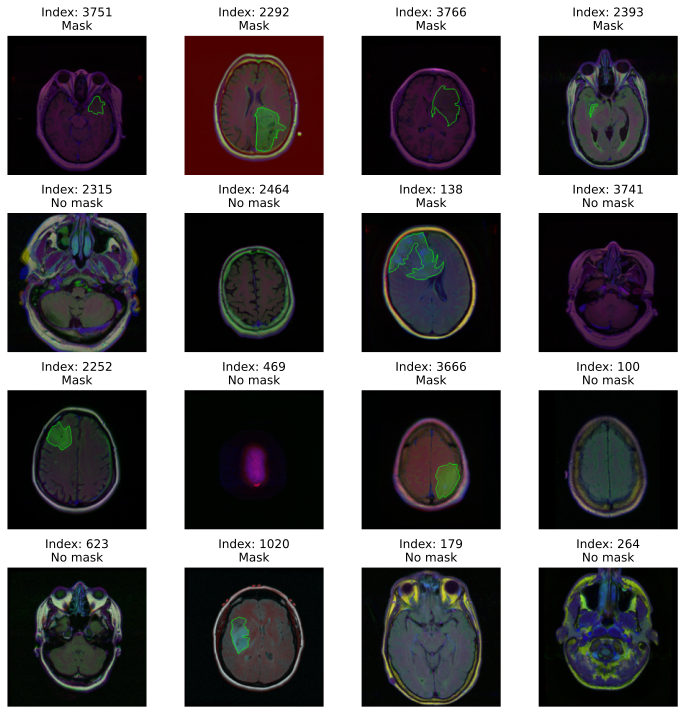

In [56]:
# Random pick 16 images from the DataFrame and make image plots

# np.random.seed(42)

# Generate 16 random indices
indices = np.random.randint(0, len(df), 16)

image_plots(df, indices)

In [57]:
df_mask = df[df["check_mask"] == 1]
# train_df = df_mask.sample(frac=0.8, random_state=42)

df_mask.head()

image_file                          mask_file  \
10  TCGA_CS_4941_19960909_11.tif  TCGA_CS_4941_19960909_11_mask.tif   
11  TCGA_CS_4941_19960909_12.tif  TCGA_CS_4941_19960909_12_mask.tif   
12  TCGA_CS_4941_19960909_13.tif  TCGA_CS_4941_19960909_13_mask.tif   
13  TCGA_CS_4941_19960909_14.tif  TCGA_CS_4941_19960909_14_mask.tif   
14  TCGA_CS_4941_19960909_15.tif  TCGA_CS_4941_19960909_15_mask.tif   

                                            mask_path  \
10  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
11  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
12  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
13  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   
14  /home/gs/Desktop/SS24 CO4 Imaging for the Life...   

                                           image_path  check_mask  
10  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
11  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
12  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
13  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1  
14  /home/gs/Desktop/SS24 CO4 Imaging for the Life...           1

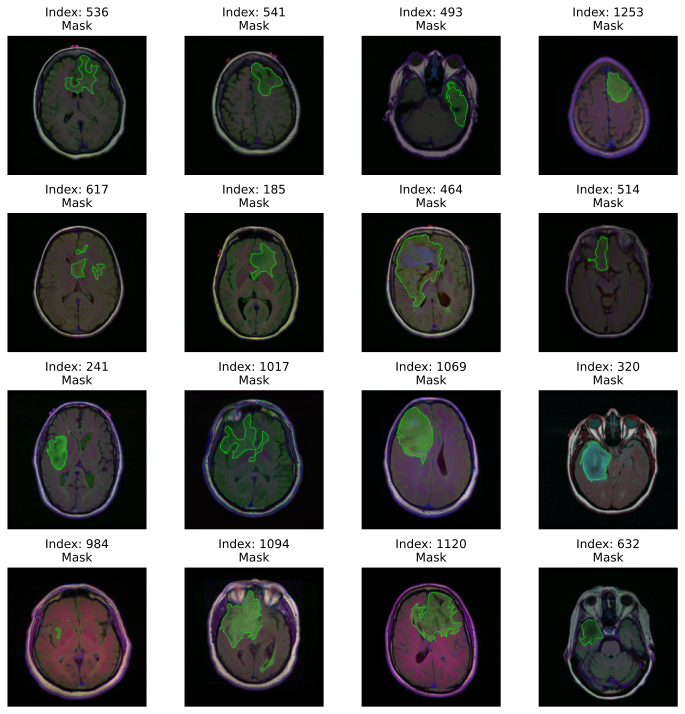

In [58]:
# Random pick 16 images from the `df_mask` and make image plots

# np.random.seed(42)
indices = np.random.randint(0, len(df_mask), 16)
image_plots(df_mask, indices)

---

<a id='sec_preprocessing'></a>

## Preprocessing

Augmentations was applied to images before the deep learning training. 


In [59]:
train_data_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomApply([transforms.RandomRotation(degrees=90)], p=0.5),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

test_data_transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToImage(),
        transforms.ToDtype(torch.float32, scale=True),
    ]
)

In [60]:
# Display the 16 images with their masks

def transformed_image_plots(df, indices):
    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i, index in enumerate(indices):
        image = Image.open(df.iloc[index]["image_path"])
        mask = Image.open(df.iloc[index]["mask_path"])
        
        image, mask = train_data_transform(image, mask)
        
        image = image.numpy().transpose(1, 2, 0)
        mask = mask.numpy().transpose(1, 2, 0)
        

        ax = axs[i // 4, i % 4]
        overlay = overlay_mask(image, mask)
        # overlay = overlay - np.min(overlay)  # Shift the values so the minimum is 0
        # overlay = overlay / np.max(overlay)  # Scale the values so the maximum is 1
        ax.imshow(overlay)
        # ax.imshow(image)
        # ax.imshow(mask, cmap="jet", alpha=0.5)
        ax.axis("off")

        mask_status = "Mask" if df.iloc[index]["check_mask"] == 1 else "No mask"
        ax.set_title(f"Index: {index}\n{mask_status}")

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

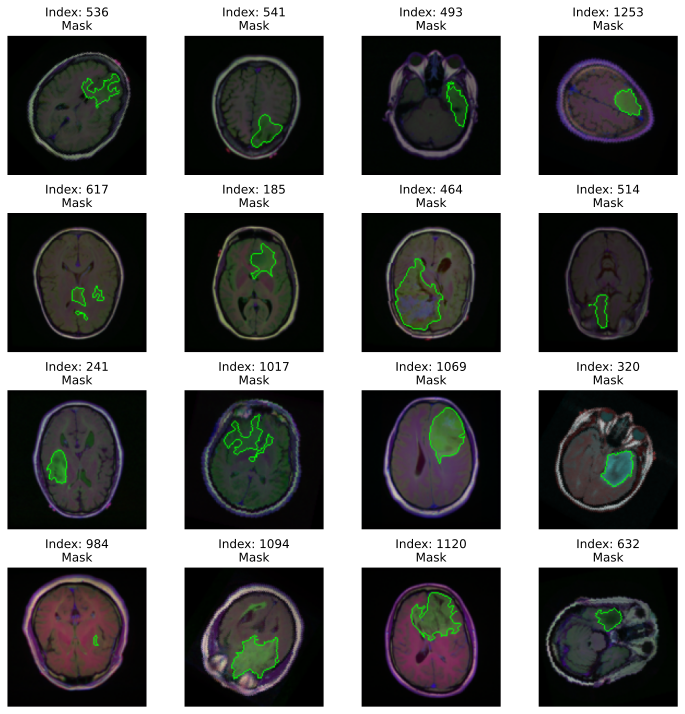

In [61]:
transformed_image_plots(df_mask, indices)

In [62]:
def plot_model_results(image, mask, predict):
    fig, axs = plt.subplots(1, 3, figsize=(10, 3.33))

    axs[0].imshow(transforms.ToPILImage()(image))
    axs[0].set_title("Image")
    axs[0].axis("off")

    axs[1].imshow(transforms.ToPILImage()(mask), cmap="gray")
    axs[1].set_title("Mask")
    axs[1].axis("off")

    axs[2].imshow(transforms.ToPILImage()(predict.squeeze(0)), cmap="gray")
    axs[2].set_title("Predicted mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()



---

<a id='sec_manual_segmentation'></a>

## Manual segmentation


In this project, a researcher who was a medical school graduate with experience in neuroradiology imaging, manually annotated FLAIR images by drawing an outline of the FLAIR abnormality on each slice to form training data for the automatic segmentation algorithm. For more details about the manual segmentation, please refer the reference. 



---

<a id='sec_automated_segmentation'></a>

## Automated segmentation

A neural network was applied to automatically segment the images in this project. 




### Dataset preparation

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device

device(type='cuda', index=0)

Only images with masks were applied for training.

Build `df_mask` for training and testing. 

In [64]:
# Class to create a custom dataset

class CustomImageDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def load_image(self, idx):
        image = Image.open(self.df.iloc[idx]["image_path"])
        mask = Image.open(self.df.iloc[idx]["mask_path"])
        return image, mask

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.df.iloc[idx]["image_path"]
        mask_name = self.df.iloc[idx]["mask_path"]

        image = Image.open(img_name)
        mask = Image.open(mask_name)

        image, mask = self.transforms(image, mask)

        return image, mask

In [65]:

# np.random.seed(42)

train_df = df_mask.sample(frac=0.8, random_state=np.random.randint(0, 1000000))
test_df = df_mask.drop(train_df.index)

# Save images in the Pytorch dataset format

train_dataset = CustomImageDataset(train_df, transforms=train_data_transform)
test_dataset = CustomImageDataset(test_df, transforms=test_data_transform)

# Load the train and test datasets

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

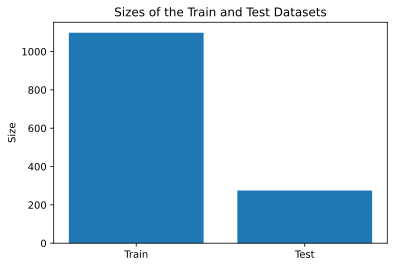

In [66]:

plt.figure(figsize=(6,4))
plt.bar(["Train", "Test"], [len(train_dataset), len(test_dataset)])
plt.ylabel('Size')
plt.title('Sizes of the Train and Test Datasets')
plt.show()


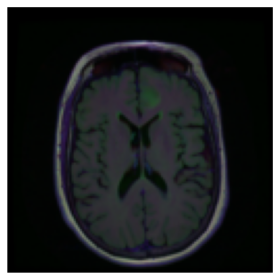

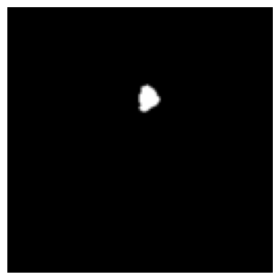

In [67]:
# Display sample images from the dataset
# np.random.seed(42)
incident = np.random.randint(0, len(train_dataset))

image, mask = train_dataset[incident]

plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(mask.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()


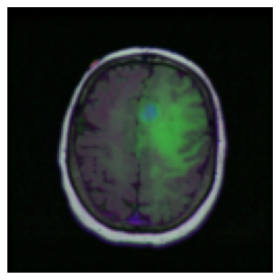

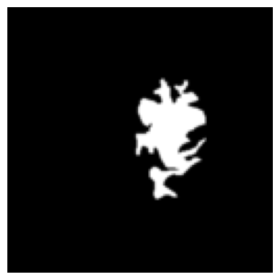

In [68]:
# Display sample images from the dataset
# np.random.seed(42)
incident = np.random.randint(0, len(test_dataset))

image, mask = test_dataset[incident]

plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.show()

plt.imshow(mask.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.show()

In [69]:
# Validate the train_loader

image, mask = next(iter(train_loader))
image.shape, mask.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16, 1, 128, 128]))

### Deep Learning Model

Use U-Net architechture for the deep learning model

In [70]:
# Model building, inspired by the U-Net from Kaggle.

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2), DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.ConvTranspose2d(
            in_channels // 2, in_channels // 2, kernel_size=2, stride=2
        )
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = nn.functional.pad(
            x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2]
        )
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.n_channels = 3
        self.n_classes = 1
        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256)
        self.up2 = Up(512, 128)
        self.up3 = Up(256, 64)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Create the UNet model
model = UNet().to(device)

### Training Image Dataset with Tumor

In [71]:
# Define the loss function and optimizer

criterion = nn.BCEWithLogitsLoss()  # Suitable for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [72]:
# Define the loss function

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.sigmoid()  # Apply sigmoid to clamp between 0 and 1
        intersection = (
            predictions * targets
        ).sum()  # Element-wise multiplication and sum
        dice = (2.0 * intersection + self.smooth) / (
            predictions.sum() + targets.sum() + self.smooth
        )
        return 1 - dice
    
dice_loss = DiceLoss()

In [73]:
def training(train_loader, test_loader, model, num_epochs = 50):
    
    torch.cuda.empty_cache()

    # torch.manual_seed(42)
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, masks in train_loader:
            optimizer.zero_grad()

            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            # Resize masks to match the size of outputs
            # masks = torch.nn.functional.interpolate(masks, size=outputs.size()[2:], mode='bilinear', align_corners=False).to(device)
            
            loss = dice_loss(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}")

        

        model.eval()
        with torch.no_grad():
            
            testing_loss = 0.0

            for images, masks in test_loader:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                preds = torch.sigmoid(outputs)
                preds = preds > 0.5  # Apply threshold

                loss = dice_loss(outputs, masks)
                testing_loss += loss.item() * images.size(0)
                
            val_loss = testing_loss / len(test_loader.dataset)
            val_loss_history.append(val_loss)

            print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
            
            if epoch % 5 == 0:

                # Visualization code (for example purposes, visualize the first batch)
                
                plot_side_by_side(images[0].cpu().permute(1,2,0), masks[0].cpu().permute(1,2,0), preds[0].cpu().numpy().squeeze())
                
                # plt.figure(figsize=(10, 5))
                # plt.subplot(1, 3, 1)
                # plt.imshow(transforms.ToPILImage()(images[0].cpu()))
                # plt.title("Input Image")
                # plt.axis("off")

                # plt.subplot(1, 3, 2)
                # plt.imshow(transforms.ToPILImage()(masks[0].cpu()), cmap="gray")
                # plt.title("Ground Truth Mask")
                # plt.axis("off")
                
                # plt.subplot(1, 3, 3)
                # plt.imshow(preds[0].cpu().numpy().squeeze(), cmap="gray")
                # plt.title("Predicted Mask")
                # plt.axis("off")
                # 
                # plt.show()
                
                #plot_model_results(images[0], masks[0], preds[0].squeeze(0))
    
    return model, train_loss_history, val_loss_history   



Epoch 1/50, Training Loss: 0.7900
Epoch 1/50, Validation Loss: 0.8710


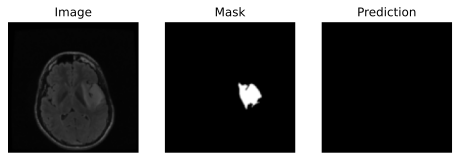

Epoch 2/50, Training Loss: 0.5115
Epoch 2/50, Validation Loss: 0.4050
Epoch 3/50, Training Loss: 0.3211
Epoch 3/50, Validation Loss: 0.3847
Epoch 4/50, Training Loss: 0.2894
Epoch 4/50, Validation Loss: 0.3321
Epoch 5/50, Training Loss: 0.2844
Epoch 5/50, Validation Loss: 0.2835
Epoch 6/50, Training Loss: 0.2479
Epoch 6/50, Validation Loss: 0.5908


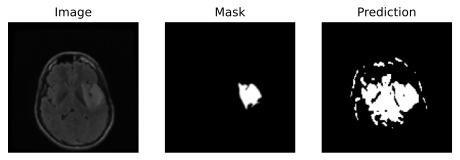

Epoch 7/50, Training Loss: 0.2664
Epoch 7/50, Validation Loss: 0.2992
Epoch 8/50, Training Loss: 0.2491
Epoch 8/50, Validation Loss: 0.2702
Epoch 9/50, Training Loss: 0.2338
Epoch 9/50, Validation Loss: 0.2800
Epoch 10/50, Training Loss: 0.2281
Epoch 10/50, Validation Loss: 0.3167
Epoch 11/50, Training Loss: 0.2212
Epoch 11/50, Validation Loss: 0.2544


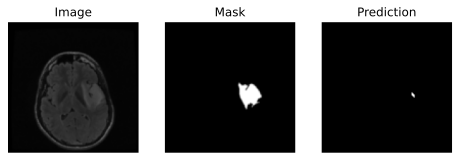

Epoch 12/50, Training Loss: 0.2192
Epoch 12/50, Validation Loss: 0.2255
Epoch 13/50, Training Loss: 0.2178
Epoch 13/50, Validation Loss: 0.2379
Epoch 14/50, Training Loss: 0.2236
Epoch 14/50, Validation Loss: 0.2480
Epoch 15/50, Training Loss: 0.2175
Epoch 15/50, Validation Loss: 0.2416
Epoch 16/50, Training Loss: 0.2211
Epoch 16/50, Validation Loss: 0.2618


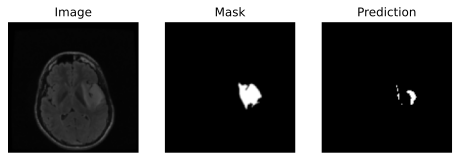

Epoch 17/50, Training Loss: 0.2159
Epoch 17/50, Validation Loss: 0.3385
Epoch 18/50, Training Loss: 0.2104
Epoch 18/50, Validation Loss: 0.2532
Epoch 19/50, Training Loss: 0.2036
Epoch 19/50, Validation Loss: 0.2359
Epoch 20/50, Training Loss: 0.1963
Epoch 20/50, Validation Loss: 0.2296
Epoch 21/50, Training Loss: 0.2233
Epoch 21/50, Validation Loss: 0.2179


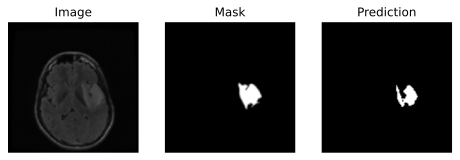

Epoch 22/50, Training Loss: 0.2030
Epoch 22/50, Validation Loss: 0.2250
Epoch 23/50, Training Loss: 0.1979
Epoch 23/50, Validation Loss: 0.2163
Epoch 24/50, Training Loss: 0.1920
Epoch 24/50, Validation Loss: 0.2004
Epoch 25/50, Training Loss: 0.1941
Epoch 25/50, Validation Loss: 0.2004
Epoch 26/50, Training Loss: 0.1931
Epoch 26/50, Validation Loss: 0.2429


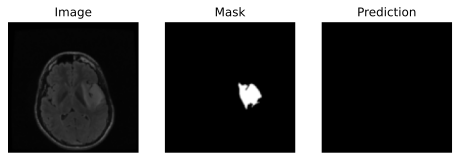

Epoch 27/50, Training Loss: 0.1912
Epoch 27/50, Validation Loss: 0.2169
Epoch 28/50, Training Loss: 0.1875
Epoch 28/50, Validation Loss: 0.2126
Epoch 29/50, Training Loss: 0.1861
Epoch 29/50, Validation Loss: 0.1895
Epoch 30/50, Training Loss: 0.1796
Epoch 30/50, Validation Loss: 0.1779
Epoch 31/50, Training Loss: 0.1857
Epoch 31/50, Validation Loss: 0.2005


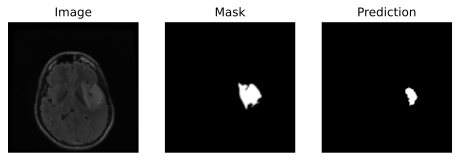

Epoch 32/50, Training Loss: 0.1762
Epoch 32/50, Validation Loss: 0.2151
Epoch 33/50, Training Loss: 0.1721
Epoch 33/50, Validation Loss: 0.1786
Epoch 34/50, Training Loss: 0.1738
Epoch 34/50, Validation Loss: 0.1784
Epoch 35/50, Training Loss: 0.1770
Epoch 35/50, Validation Loss: 0.1845
Epoch 36/50, Training Loss: 0.1712
Epoch 36/50, Validation Loss: 0.1840


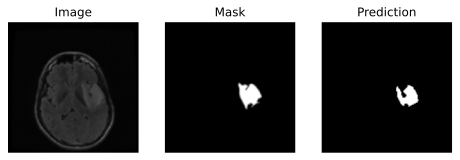

Epoch 37/50, Training Loss: 0.1654
Epoch 37/50, Validation Loss: 0.1797
Epoch 38/50, Training Loss: 0.1655
Epoch 38/50, Validation Loss: 0.1982
Epoch 39/50, Training Loss: 0.1685
Epoch 39/50, Validation Loss: 0.1751
Epoch 40/50, Training Loss: 0.1647
Epoch 40/50, Validation Loss: 0.1993
Epoch 41/50, Training Loss: 0.1674
Epoch 41/50, Validation Loss: 0.1880


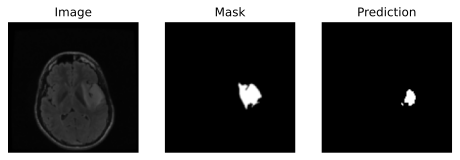

Epoch 42/50, Training Loss: 0.1644
Epoch 42/50, Validation Loss: 0.1686
Epoch 43/50, Training Loss: 0.1550
Epoch 43/50, Validation Loss: 0.1617
Epoch 44/50, Training Loss: 0.1795
Epoch 44/50, Validation Loss: 0.1813
Epoch 45/50, Training Loss: 0.1672
Epoch 45/50, Validation Loss: 0.1682
Epoch 46/50, Training Loss: 0.1588
Epoch 46/50, Validation Loss: 0.1655


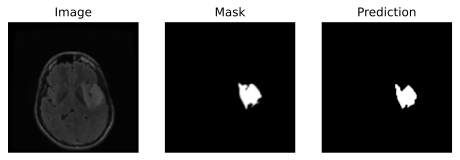

Epoch 47/50, Training Loss: 0.1569
Epoch 47/50, Validation Loss: 0.1441
Epoch 48/50, Training Loss: 0.1557
Epoch 48/50, Validation Loss: 0.1677
Epoch 49/50, Training Loss: 0.1536
Epoch 49/50, Validation Loss: 0.1497
Epoch 50/50, Training Loss: 0.1475
Epoch 50/50, Validation Loss: 0.1808


In [75]:
model, train_loss_history, val_loss_history = training(train_loader, test_loader, model, num_epochs=50)

In [76]:
torch.save(model.state_dict(), "unet.pth")

In [74]:
model = UNet().to(device)  # Replace with your actual model architecture
model.load_state_dict(torch.load("unet.pth"))

<All keys matched successfully>

---

<a id='sec_evaluation'></a>

## Evaluation

The ground truth mask (depicted by the green contour) and the predicted mask (represented by the red contour) are overlaid on the original image to visualize the evaluation.

In [75]:
def pred_plots(df, indices):

    fig, axs = plt.subplots(4, 4, figsize=(10, 10))

    for i, index in enumerate(indices):
        image = Image.open(df.iloc[index]["image_path"])
        mask = Image.open(df.iloc[index]["mask_path"])

        ax = axs[i // 4, i % 4]
        overlay = overlay_mask(image, mask)

        output = model(test_data_transform(image).unsqueeze(0).to(device))
        output = torch.sigmoid(output)
        output = output.squeeze().cpu().detach().numpy()

        overlay = overlay_output(overlay, output)

        ax.imshow(overlay)

        # ax.imshow(image)
        # ax.imshow(mask, cmap="jet", alpha=0.5)
        ax.axis("off")

        ax.set_title(f"Index: {index}")

    plt.suptitle("Green Contour: Ground Truth Mask\nRed Contour: Predicted Mask")

    plt.tight_layout()
    plt.show()

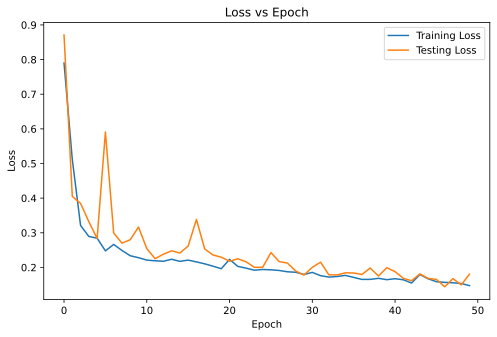

In [79]:
# Plot the loss history with epoch

plot_losses(train_loss_history, val_loss_history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

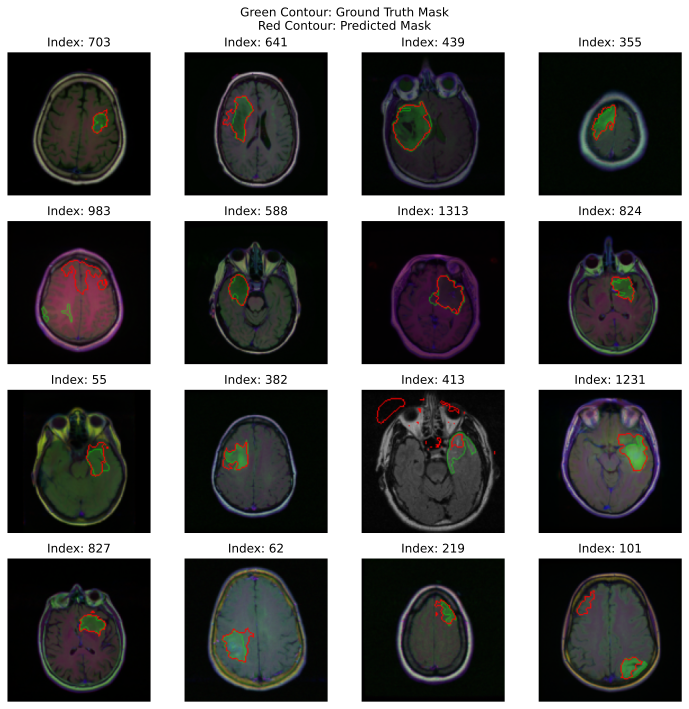

In [76]:
# Random pick 16 images from the `df_mask` and make image plots with the predicted mask

# Green contour presents the ground truth mask
# Red contour presents the predicted mask

# np.random.seed(42)
indices = np.random.randint(0, len(df_mask), 16)
pred_plots(df_mask, indices)

---

<a id='sec_discussion'></a>

## Discussion
In this project, a deep learning-based method was developed to segment the cancerous regions of brain tumors. The U-Net deep learning architecture, widely recognized for its effectiveness in bioimage analysis, was implemented for the segmentation task. The model demonstrated promising results, with a training loss rate of 0.1628 and a validation loss rate of 0.1807 after 50 epochs. These results suggest that the algorithm is capable of generating accurate segmentations. The model was trained in approximately 60 minutes on a GPU.

However, there is potential for further optimization of the segmentation accuracy through improved image preprocessing steps. One approach could be to fine-tune the normalization parameters for the images to minimize variability. Implementing noise reduction and contrast enhancement could also enhance the quality of the MRI images, making tumor regions more distinguishable from normal tissue. Additionally, the use of a pretrained model for skull stripping during image preprocessing could be explored. Due to the project's time constraints, a universal image processing method that could unbiasedly preprocess all 1373 images in the dataset was not identified.

The choice of loss function is another crucial aspect of deep learning programming. Exploring different loss functions could potentially improve the model's performance.

The original dataset also includes images with blank masks (indicating brains without tumors). To simplify this course project, I only used images known to have masks. It could be intriguing to incorporate images without tumors into the image preprocessing to test if the algorithm can accurately handle images without tumors.




---

<a id='sec_references'></a>

## References

Mateusz Buda, AshirbaniSaha, Maciej A. Mazurowski "Association of genomic subtypes of lower-grade gliomas with shape features automatically extracted by a deep learning algorithm." Computers in Biology and Medicine, 2019.

https://www.kaggle.com/code/truthisneverlinear/attention-u-net-pytorch

The code in this Jupyter Notebook was developed with assistance from GitHub Copilot. Initially, I wrote the code, and then GitHub Copilot provided revisions and improvements.

For more information about the dataset:
[https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation](https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation)

